In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pyPI as pi
import cv2

In [8]:
'''
Use this notation if you want to use circles instead lines
diameter = 7e-8  # Diámetro del glóbulo rojo en metros
# Diámetro en píxeles
diameter_pixels = max(5, min(int(diameter / lambda_ * x_size), min(x_size, y_size) // 2))

# Definir posiciones fijas para los glóbulos rojos (en píxeles)
fixed_positions = [(100, 400), (500, 100), (800, 250)]  # (x, y) en píxeles

# Definir intensidades específicas para cada glóbulo rojo en sample_image
intensity_values = [100, 180, 230]  # Valores entre 0 y 255
'''

'''
fixed_positions = [100, 250, 400]  # Posiciones en el eje y

# Definir matrices específicas para cada línea en sample
line_matrices = [
    pi.jones_matrix(np.pi, np.pi/2),        # Línea 1
    pi.jones_matrix(np.pi/3, 0),      # Línea 2
    pi.jones_matrix(np.pi/3, np.pi/2)       # Línea 3
]
'''

'\nfixed_positions = [100, 250, 400]  # Posiciones en el eje y\n\n# Definir matrices específicas para cada línea en sample\nline_matrices = [\n    pi.jones_matrix(np.pi, np.pi/2),        # Línea 1\n    pi.jones_matrix(np.pi/3, 0),      # Línea 2\n    pi.jones_matrix(np.pi/3, np.pi/2)       # Línea 3\n]\n'

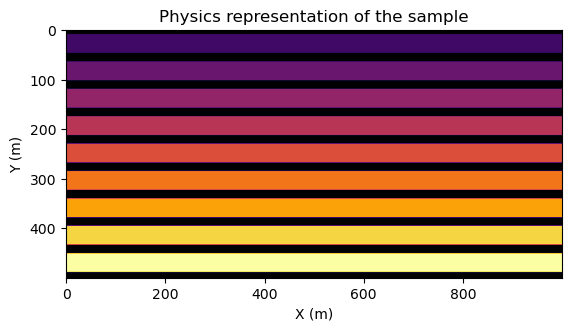

In [116]:
# Initialize the environment and extract relevant variables
sample, sample_image, X, Y = pi.initialize_environment()

# Parameters for line orientations (angles in radians)
# Common angular values are chosen for better visual reference
angles = [0, np.pi/8, np.pi/7, np.pi/6, np.pi/5, np.pi/4, np.pi/3, np.pi/2, np.pi]

# Define fixed positions for horizontal lines (in pixels)
# These positions are spaced evenly across the image
fixed_positions = np.arange(10, 500, 500 // len(angles))  

# Generate Jones matrices for each corresponding angle
line_matrices = [pi.jones_matrix(np.pi/4, angle) for angle in angles]

# Add lines to the sample with defined thickness
# The thickness is adjusted proportionally to the number of angles
sample = pi.add_lines(fixed_positions, line_matrices, sample_image, sample, grosor=350 // len(angles))


In [117]:
#from scipy.linalg import eig

# Inicialización de alpha_sample con la misma forma que sample pero sin las dimensiones de las matrices
#alpha_sample = np.zeros(sample.shape[:2])

# Cálculo de alpha para cada elemento en sample
#for i in range(sample.shape[0]):
#    for j in range(sample.shape[1]):
#        S = sample[i, j]  # Matriz actual en el mapeo
#        eigenvalues, eigenvectors = eig(S)
#        alpha_calculado = np.arctan2(np.real(eigenvectors[1, 0]), np.real(eigenvectors[0, 0]))
#        alpha_sample[i, j] = alpha_calculado

In [118]:
# Inicialización de alpha_sample con NaN para distinguir elementos no calculados
from scipy.linalg import eig
alpha_sample = np.full(sample.shape[:2], np.nan)

# Evaluar la función solo en las posiciones fijas
for i in fixed_positions:
    for j in range(sample.shape[1]):  # o `for j in fixed_positions:` si deseas una cuadrícula
        S = sample[i, j]  # Matriz actual en el mapeo
        eigenvalues, eigenvectors = eig(S)
        alpha_calculado = np.arctan2(np.real(eigenvectors[1, 0]), np.real(eigenvectors[0, 0]))
        alpha_sample[i, j] = alpha_calculado

In [119]:
np.isclose(angles, alpha_sample[fixed_positions,0], atol=1e-6)

array([ True,  True,  True,  True,  True, False, False, False, False])

In [120]:
E_in = pi.polarization_basis_set('P45')

In [121]:
alpha_HWP_IS, alpha_QWP_IS = pi.PSG_calculator(E_in, pi.polarization_basis_set('L'), p = True)
Eis = pi.field_notation(pi.PSG(alpha_HWP_IS, alpha_QWP_IS) @ E_in, p = True)
print(Eis)

HWP: alpha_1 = 0.0000π
QWP: alpha_2 = 0.0000π
0.70711
0.70711
0.5π

[[0.70710678+0.j        ]
 [0.        +0.70710678j]]


In [122]:
alpha_HWP_R, alpha_QWP_R = pi.PSG_calculator(E_in, pi.polarization_basis_set('L'), p = True)
Er = pi.field_notation(pi.PSG(alpha_HWP_R, alpha_QWP_R) @ E_in, p = True)
print(Er)

HWP: alpha_1 = 0.0000π
QWP: alpha_2 = 0.0000π
0.70711
0.70711
0.5π

[[0.70710678+0.j        ]
 [0.        +0.70710678j]]


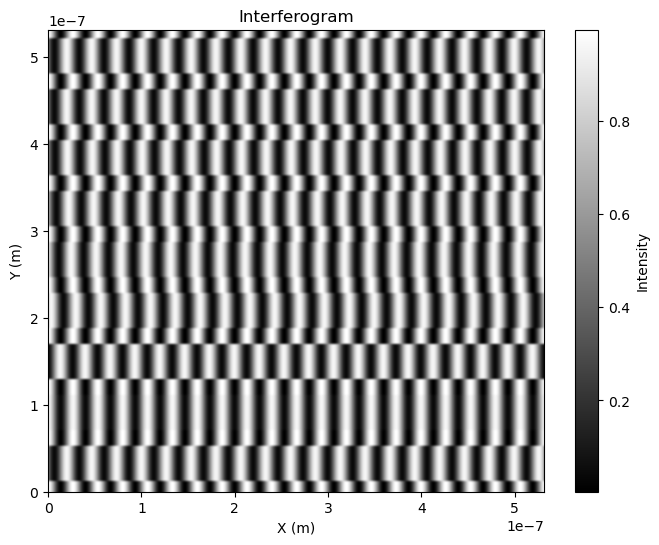

In [123]:
I, info,E_r, E_s = pi.sample_intensity(Er, Eis, sample, X, Y)

In [124]:
#optimal_delta_chi = np.zeros(sample.shape[:2])
#optimal_alpha = np.zeros(sample.shape[:2])

# Cálculo de alpha para cada elemento en sample
#for i in range(sample.shape[0]):
#    for j in range(sample.shape[1]):
#        chi, alpha = pi.birefringence_by_minimization(Eis, E_s[i,j])
#        optimal_delta_chi[i, j] = chi
#        optimal_alpha[i, j] = alpha

In [125]:
# Inicialización con NaN para identificar elementos no calculados
optimal_delta_chi = np.full(sample.shape[:2], np.nan)
optimal_alpha = np.full(sample.shape[:2], np.nan)

# Evaluar la función solo en las posiciones fijas
for i in fixed_positions:
    for j in range(sample.shape[1]):  # o `for j in fixed_positions:` si deseas una cuadrícula
        chi, alpha = pi.birefringence_by_minimization(Eis, E_s[i, j])
        optimal_delta_chi[i, j] = chi
        optimal_alpha[i, j] = alpha

In [126]:
optimal_delta_chi[fixed_positions,0]

array([0.7853915 , 0.78543553, 0.78544085, 0.78542361, 0.78538292,
       0.78539674, 0.78540656, 0.78536509, 0.7853915 ])

In [132]:
np.isclose(np.pi/4, optimal_delta_chi[fixed_positions,0], atol=1e-4)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [133]:
np.isclose(angles, optimal_alpha[fixed_positions,0], atol=1e-4)

array([ True,  True,  True,  True,  True,  True,  True,  True, False])

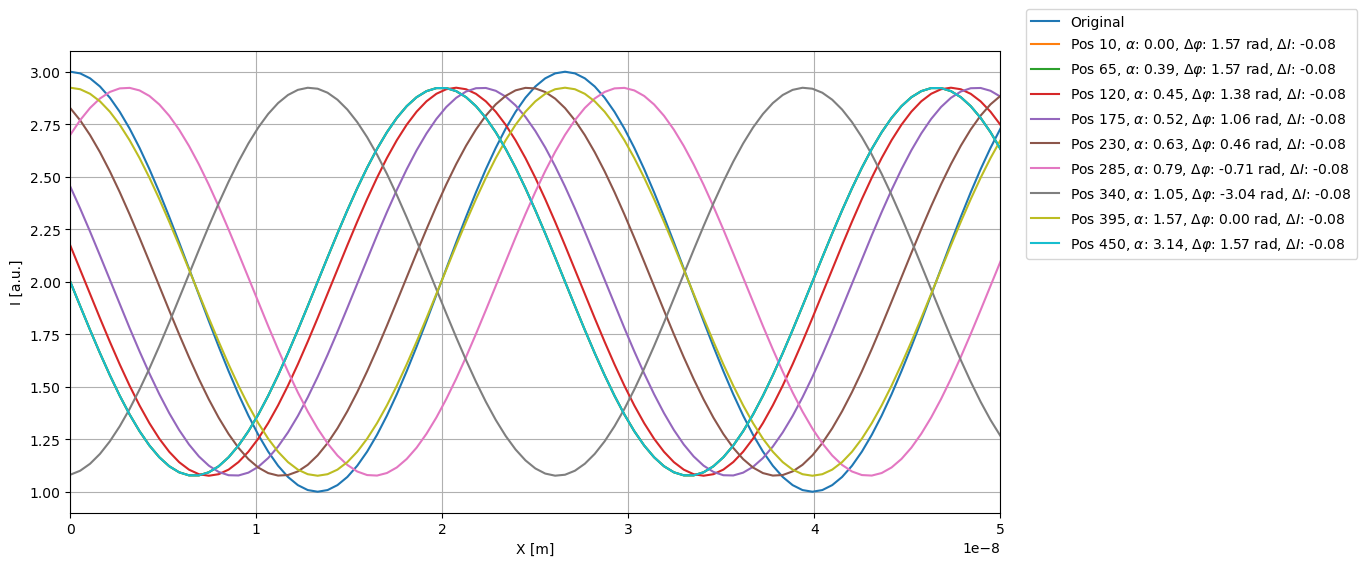

In [134]:
# Aumentar el tamaño de la figura para mejor visualización
plt.figure(figsize=(12, 6))

# Arreglos para almacenar desfases y cambios en la intensidad
desfases = []
cambios_intensidad = []

# Graficar la curva original
plt.plot(X[0], I[0], label="Original")

# Calcular el desfase y el cambio en la intensidad
for i, pos in enumerate(fixed_positions):
    # Cálculo del desfase con la nueva función
    desfase = pi.calculate_phase_shift(I[0], I[pos], X[0])
    
    # Cálculo del cambio en la intensidad
    cambio_intensidad = np.max(I[pos]) - np.max(I[0])
    
    # Guardar en los arreglos
    desfases.append(desfase)
    cambios_intensidad.append(cambio_intensidad)
    
    # Graficar cada curva con la leyenda correspondiente
    plt.plot(X[0], I[pos], label=rf"Pos {pos}, $\alpha$: {angles[i % len(angles)]:.2f}, $\Delta\varphi$: {desfase:.2f} rad, $\Delta I$: {cambio_intensidad:.2f}")


plt.xlabel('X [m]')
plt.ylabel('I [a.u.]')
plt.xlim(0, 0.5e-7)

# Colocar la leyenda fuera del gráfico (a la derecha)
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.82))

plt.grid(True)
plt.show()

In [135]:
b = info[0]
m = info[1]
vartheta = info[2]


In [136]:
vartheta[320,0] == vartheta[0,0]

False

In [137]:
from scipy.ndimage import gaussian_filter1d  # Para suavizar la curva

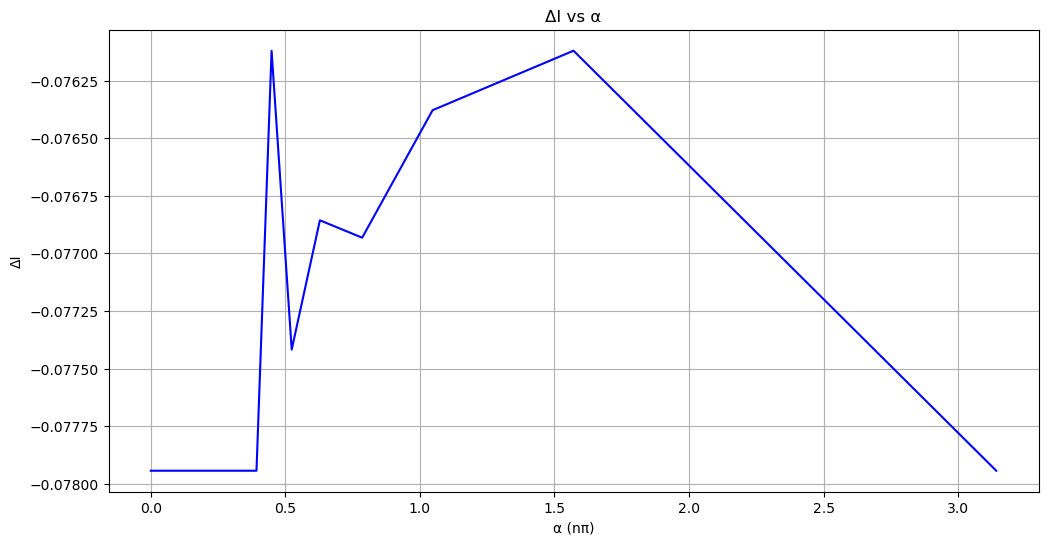

In [138]:
# Suavizar la curva usando una función Gaussiana
cambios_intensidad_suave = gaussian_filter1d(cambios_intensidad, sigma=0.01)

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(angles , cambios_intensidad_suave, label='ΔI (suavizado)', color='b')
plt.xlabel('α (nπ)')
plt.ylabel('ΔI')
plt.grid(True)
plt.title("ΔI vs α")
plt.show()

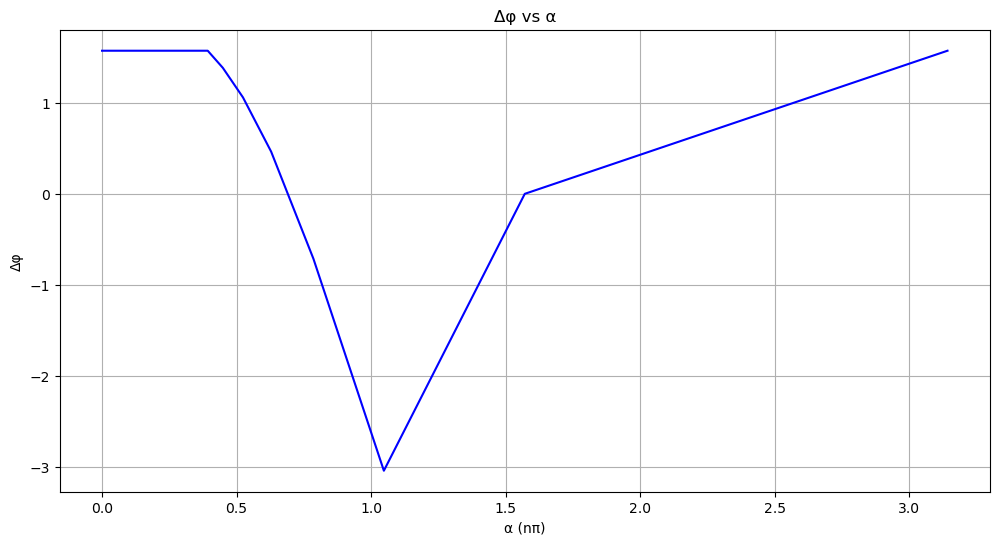

In [139]:
# Suavizar la curva usando una función Gaussiana
desfases_suavizado = gaussian_filter1d(desfases, sigma=0.01)

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(angles , desfases_suavizado, label='Δφ (suavizado)', color='b')
plt.xlabel('α (nπ)')
plt.ylabel('Δφ')
plt.grid(True)
plt.title("Δφ vs α")
plt.show()